In [1]:
from notebooks_tools import *
from gbdt_tools import *
from xgboost import plot_importance
%matplotlib inline

/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Welcome to ROOTaaS 6.06/02

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Define parameters
set the GBDTs hyper-parameters

In [2]:
data_type_arr=['MC_BNB','openCOSMIC_MC'] 
nevents_train_arr=[300000,200000] 
parameters = dict({ 
        'evnts_frac':1,# events fraction to process
        'debug':2, # prints out information during the processes
        'scale_pos_weight':2., # Balancing of positive and negative weights.
        'objective':'multi:softprob', # Specify the learning task and the corresponding learning objective or a custom objective function to be used      
        #  in previous rounds was'objective':'binary:logistic'
        'eta':0.025, # Boosting learning rate        
        'eval_metric':'merror', # a custom evaluation metric      
        'silent':True, # Whether to print messages while running boosting
        'nthread':6, # Number of parallel threads used to run xgboost.     
        'min_child_weight':4, # Minimum sum of instance weight(hessian) needed in a child.        
        'max_depth':13,# Maximum tree depth for base learners
        'gamma':0.7, # Minimum loss reduction required to make a further partition on a leaf node of the tree.
        'colsample_bytree':0.5, # Subsample ratio of columns when constructing each tree
        'subsample':0.8, # Subsample ratio of the training instance       
        'num_class':5, #  If early stopping occurs...     
        'Ntrees':500,        
        'Nfolds':10,
        'num_round':200
#         'reg_alpha':1e-5 # L1 regularization term on weights
        })
# [http://xgboost.readthedocs.io/en/latest/python/python_api.html]
train_filename = []
models_path = '/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/GBDTmodels'
for data_name,nevnts in zip(data_type_arr,nevents_train_arr):
    train_filename.append(TrainingSampleFileName( data_name , nevnts , main_path))    
    print_filename( train_filename[-1] , "input: traininig sample file" )

input: traininig sample file
/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/TrainingSamples/trainsample_300000_tracks_MC_BNB.csv
input: traininig sample file
/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/TrainingSamples/trainsample_200000_tracks_openCOSMIC_MC.csv


# comments:
katherine gives in parameter_opt:
eta=0.05
max_depth=9
gamma=0
colsample_bytree=0.8


# Load the data
from the training files

In [3]:
data,label,weight = boost_multiscore.load_data( bnb_mc_filename=train_filename[0] , 
                                               corsika_mc_filename=train_filename[1] ,   
                                               debug=parameters['debug'] ,
                                               feature_names=feature_names ,
                                               tracks_frac=parameters['evnts_frac'] )

took only a fraction of 1 of tracks from MC-BNB and CORSIKA samples:
140370 protons, 30221 pions, 61410 muons, 55994 em
200000 cosmic tracks


In [4]:
data

array([[  7.70000000e+01,   1.51080000e+01,  -4.09110000e+01, ...,
         -5.44300000e+00,   2.21200000e+03,   1.47000000e-01],
       [  9.00000000e+00,   3.62800000e+00,  -4.56700000e+00, ...,
         -1.43760000e+01,   2.21200000e+03,   5.60000000e-02],
       [  2.40000000e+01,   5.12500000e+00,  -5.31650000e+01, ...,
         -8.57720000e+01,   2.21200000e+03,   8.00000000e-02],
       ..., 
       [  5.30000000e+01,   1.22600000e+01,  -1.49120000e+01, ...,
         -9.99900000e+03,  -1.10000000e+01,   3.80000000e-02],
       [  1.00000000e+00,   7.03000000e-01,  -1.05761000e+02, ...,
         -9.99900000e+03,   1.30000000e+01,   8.01200000e+00],
       [  5.30000000e+01,   1.02030000e+01,   2.94600000e+00, ...,
         -9.99900000e+03,   2.21200000e+03,   1.15000000e-01]])

# cross-validation step
from the training files

In [6]:
do_cross_validation = yesno('cross validate?')
if do_cross_validation:
    test_error,test_falsepos,test_falseneg,scores = boost_multiscore.run_cv( data , label , weight , parameters , Nskf=10)

cross validate? [Y/n] yes
enumerate(skf): <enumerate object at 0x122623b40>
On fold 0
On fold 1
On fold 2
On fold 3
On fold 4
On fold 5
On fold 6
On fold 7
On fold 8
On fold 9


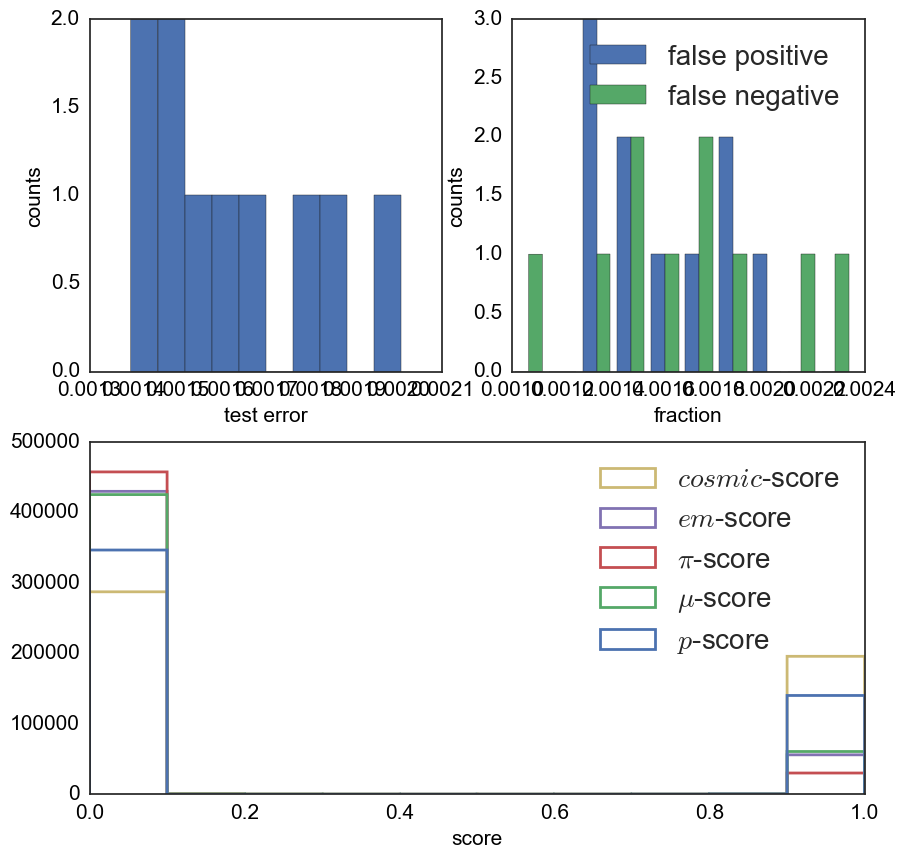

In [7]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2,2,1)
plt.hist(test_error);
set_axes(ax,x_label='test error',y_label='counts',fontsize=15)

ax = fig.add_subplot(2,2,2)
plt.hist([test_falsepos,test_falseneg],label=['false positive','false negative']);
set_axes(ax,x_label='fraction',y_label='counts',fontsize=15)
plt.legend(fontsize=20,loc='best')

ax = fig.add_subplot(2,1,2)
plt.hist([scores[0],scores[1],scores[2],scores[3],scores[4]],
         label=['$p$-score','$\\mu$-score','$\\pi$-score','$em$-score','$cosmic$-score'],
         histtype='step',linewidth=2);
set_axes(ax,x_label='score',fontsize=15)
plt.legend(fontsize=20,loc='best')

# optimization of the hyper-parameters

In [ ]:
do_optimize_paramters = yesno('optimize parameters?')
if do_optimize_paramters:
    results_optimize = test_error,test_falsepos,test_falseneg,scores = boost_multiscore.parameter_opt( data , label , weight , parameters )

In [ ]:
results_optimize

# build the tree

In [4]:
model_name = 'model_2017Jan28'
do_make_bdt = yesno('make %s bdt?'%model_name)
if do_make_bdt:
    bdt = boost_multiscore.make_bdt( data , label , weight , parameters)

make bdt? [Y/n] yes


In [11]:
# save the as-built bdt 
print 'bdt:',bdt

bdt: <xgboost.core.Booster object at 0x118374690>


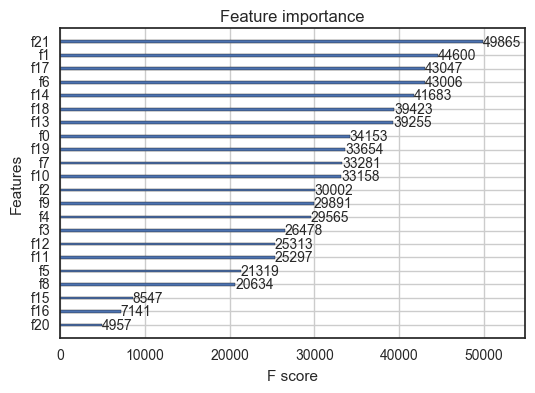

In [13]:
plot_importance(bdt)

In [ ]:
# plot importances with features names...
outfile = open('xgb.fmap', 'w')
i = 0
for feat in feature_names:
    outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    i = i + 1
outfile.close()


importance = Booster.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance',fontsize=22)
plt.xlabel('relative importance',fontsize=22)
plt.show()
plt.gcf().savefig( models_path + '/importances_'+model_name+'.pdf')

In [5]:
bdt.save_model(models_path + '/'+model_name+'.bst')